In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from astropy.constants import au, R_sun, R_jup


In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc, precision_recall_curve

### Utils

In [3]:
def get_example(index, folder, data, get_info = True, only_info = False):
    
    query_index = data[data["index"] == index]
    local_filename = query_index[query_index["view"] == "Local"]["filename"].values[0]
    global_filename = query_index[query_index["view"] == "Global"]["filename"].values[0]
    
    info = {}
    if (get_info):
        info = {
            'target': data[data["index"] == index]['target'].values[0],
            'satellite': data[data["index"] == index]['satellite'].values[0],
            'label': data[data["index"] == index]['label'].values[0],
            'r_s': query_index["star_radius"].values[0],
            'r_p': query_index["k"].values[0] * query_index["star_radius"].values[0] * R_sun /R_jup ,
            'k': query_index["k"].values[0],
            'p': query_index["period"].values[0],
            'a_os': query_index["aos"].values[0],
            'i': query_index["i"].values[0],
            't_0': query_index["t0"].values[0]
        }

        if (only_info):
            return info

    data_global = np.load(f"{folder}/{global_filename}")
    data_local = np.load(f"{folder}/{local_filename}")

    return data_local, data_global, info

def plot_views(index, folder, data, title_local = '', title_global = ''):
    
    data_local, data_global, info = get_example(index, folder, data)
    print(info)
    
    
    textstr = '\n'.join((
        r'$r_{s}=%.2f$' % (info['r_s'], ),
        r'$r_{p}=%.2f$' % (info['r_p'], ),
        r'$k=%.2f$' % (info['k'], ),
        r'$p=%.6f$' % (info['p'], ),
        r'$a_{os}=%.2f$' % (info['a_os'], ),
        r'$i=%.4f$' % (info['i'], ),
        r'$t_{0}=%.3f$' % (info['t_0'], )
    ))
    
    title_local += f"{info['target']}({info['satellite']}). {info['label']}"
    title_global += f"{info['target']}({info['satellite']}). {info['label']}"

    fig = plt.figure(figsize=(12, 4)) 
    ax = fig.add_subplot(1, 2, 1)
    plt.title(title_local, fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    plt.ylim(-1.1, 0.5)
    plt.plot(data_local[0, :], data_local[1,:], 'b.')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    ax.text(0.02, 0.5, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)

    ax = fig.add_subplot(1, 2, 2)
    plt.title(title_global, fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    plt.ylim(-1.1, 0.5)
    plt.plot(data_global[0, :], data_global[1,:], 'b.')

    plt.show()

<img src="experimentos.png"/>

<img src="experimentos_table.png"/>


Test-Set proposed: 2 inputs (Global and Local). Dimensions: 201x1 and 61x1. (Shallue and Vanderburg (2018), Yu et al. (2019) ).

Test-Set Yeh & Jiang: 1 input. Dimensions: 144x1. (216x1, 288x1 and 360x1 are not available).

Yeh & Jiang provides 5 trained models:

---

name| period    | input

P12 | p = 1 ∼ 2 | 144

P23 | p = 2 ∼ 3 | 216

P34 | p = 3 ∼ 4 | 288

P45 | p = 4 ∼ 5 | 360 


### Consequently:

<b> A1 can de calculated directly </b>

<b> A2 can de calculated with two methods: </b>


1) Reduce the model input Global View from 201x1 to 144x1 (removing the training weights necessary to adjust the new dimension) + preserve the inputs for local (61x1) + reduce the Yeh&Jiang input from 144x1 to 61x1 for Local View. 


2) Expanding the 144x1 (Yeh and Jiang) to 201x1 for Global View input and create a 61x1 window for Local View input. Note: We cannot generate a Local View curve with the Shallue and Vanderburg (2018) proposed method  without a trial period (not provided by Yeh and Jiang).  (preserving the weights).
 

In [4]:
# load
data_train_full_proposed = pd.read_csv('../csv/data_train_full.csv')
data_test_without_label_proposed = pd.read_csv('../csv/data_test_without_label.csv')
data_test_full_proposed = pd.read_csv('../csv/data_test_full.csv')


# check consistencia 
print("Total examples")
print("Train/Validation: ", data_train_full_proposed[data_train_full_proposed["label"] == "PC"].shape[0]//4  + data_train_full_proposed[data_train_full_proposed["label"] == "NOT_PC"].shape[0]//3)
print("Test: ", data_test_full_proposed[data_test_full_proposed["label"] == "PC"].shape[0]//4  + data_test_full_proposed[data_test_full_proposed["label"] == "NOT_PC"].shape[0]//3)


print()
print("Total PC and NOT_PC")
print("PC: ", data_train_full_proposed[data_train_full_proposed["label"] == "PC"].shape[0]//4 + data_test_full_proposed[data_test_full_proposed["label"] == "PC"].shape[0]//4 )
print("NOT_PC", data_train_full_proposed[data_train_full_proposed["label"] == "NOT_PC"].shape[0]//3 + data_test_full_proposed[data_test_full_proposed["label"] == "NOT_PC"].shape[0]//3 )

Total examples
Train/Validation:  11641
Test:  1294

Total PC and NOT_PC
PC:  2074
NOT_PC 10861


In [5]:
num_PC_test = data_test_full_proposed[data_test_full_proposed["label"] == "PC"].shape[0]//4
num_NOT_PC_test = data_test_full_proposed[data_test_full_proposed["label"] == "NOT_PC"].shape[0]//3

print(num_PC_test)
print(num_NOT_PC_test)

236
1058


In [6]:
print(np.unique(data_test_full_proposed[data_test_full_proposed["label"] == "PC"]["index"]).shape[0])
print(np.unique(data_test_full_proposed[data_test_full_proposed["label"] == "NOT_PC"]["index"]).shape[0])

236
1058


In [7]:
final_model_proposed = keras.models.load_model(f'../models/FINAL_astronet_final.h5')
final_model_proposed.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_global (InputLayer)      [(None, 201, 1)]     0           []                               
                                                                                                  
 conv1d_504 (Conv1D)            (None, 201, 16)      96          ['Input_global[0][0]']           
                                                                                                  
 conv1d_505 (Conv1D)            (None, 201, 16)      1296        ['conv1d_504[0][0]']             
                                                                                                  
 max_pooling1d_252 (MaxPooling1  (None, 99, 16)      0           ['conv1d_505[0][0]']             
 D)                                                                                        

## Metrics A1

<img src="experimentos_table.png"/>


In [8]:
def metric_a1():
    folder = "../GeneratedSamples"
    predictions = []
    predictions_score = []
    true_label = []
    for index in np.unique(data_test_full_proposed["index"]):
        #print(index)
        data_local, data_global, _ = get_example(index, folder, data_test_full_proposed, False)

        prediction = final_model_proposed.predict( [data_global[1,:].reshape(1,-1), data_local[1,:].reshape(1,-1)] )[0][0][0]
        predictions_score.append(prediction)
        if (prediction >= 0.5):
            predictions.append('PC')
        else:
            predictions.append('NOT_PC')

        true_label.append(data_test_full_proposed[data_test_full_proposed['index'] == index]['label'].values[0])

    print(len(predictions))
    print(len(true_label))

    predictions_ = []
    true_label_ = []

    for p in predictions:
        if (p == 'PC'):
            predictions_.append(1)
        else:
            predictions_.append(0)

    for l in true_label:
        if (l == 'PC'):
            true_label_.append(1)
        else:
            true_label_.append(0)

    print(len(predictions_))
    print(len(true_label_))
    

    np.set_printoptions(precision=2)
    report = classification_report(true_label_, predictions_,  output_dict = True)
    auc_roc = roc_auc_score(true_label_, predictions_score)

    precision, recall, thresholds = precision_recall_curve(true_label_, predictions_score)
    auc_pr = auc(recall, precision)

    print(report)
    print()
    print("-----------")
    print("Metrics A1")
    print("-----------")
    print("Accuracy: ", report['accuracy'])
    print("PC Precision: ", report['1']['precision'])
    print("PC Recall: ", report['1']['recall'])
    print("NOT_PC Precision: ", report['0']['precision'])
    print("NOT_PC Recall: ", report['0']['recall'])
    print()
    print("auc_pr:", auc_pr)
    print("auc_roc: ", auc_roc)


In [7]:
metric_a1()

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step
1294
1294
1294
1294
{'0': {'precision': 0.9962157048249763, 'recall': 0.995274102079395, 'f1-score': 0.9957446808510637, 'support': 1058}, '1': {'precision': 0.9789029535864979, 'recall': 0.9830508474576272, 'f1-score': 0.9809725158562369, 'support': 236}, 'accuracy': 0.9930448222565688, 'macro avg': {'precision': 0.9875593292057372, 'recall': 0.989162474768511, 'f1-score': 0.9883585983536503, 'support': 1294}, 'weighted avg': {'precision': 0.9930582015079122, 'recall': 0.9930448222565688, 'f1-score': 0.9930505302028573, 'support': 1294}}

-----------
Metrics A1
-----------
Accuracy:  0.9930448222565688
PC Precision:  0.9789029535864979
PC Recall:  0.9830508474576272
NOT_PC Precision:  0.9962157048249763
NOT_PC Recall:  0.995274102079395

auc_pr: 0.9971877292567725
auc_roc:  0.9991229053859216


## Metrics A2


<img src="experimentos_table.png"  />



### Load Test-set Yeh & Jiang (144x1 input) 

In [9]:
### Test-set Yeh & Jiang (144 input) 
# Note: the dataset available only includes input of 144.
FOLDER = '../YehJiang/tardata/'

list_xtest=np.loadtxt(FOLDER + 'ALL_tesp1dns16_x.txt',unpack=True)
list_ytest=np.loadtxt(FOLDER + 'ALL_tesp1dns16_y.txt',unpack=True)

xtest=np.transpose(np.array(list_xtest[:]))
ytest=np.transpose(np.array(list_ytest[:]))


X_test = np.expand_dims(xtest, axis=2)
Y_test=np.expand_dims(ytest, axis=1)

#print shape
print("test shape=",X_test.shape, Y_test.shape)


test shape= (9600, 144, 1) (9600, 1)


In [10]:
count_PC = 0
count_non_PC = 0
for target in Y_test:
    if (target[0] == 1.0):
        count_PC+=1
    else:
        count_non_PC+=1
    #print(target[0])

In [11]:
print(count_PC)
print(count_non_PC)

4800
4800


### Method 1 for calculate metrics A2
Reduce the AstroNet model input Global View from 201x1 to 144x1 (removing the training weights necessary to adjust the new dimension) + preserve the inputs for local (61x1) + reduce the Yeh&Jiang input from 144x1 to 61x1 for Local View.

In [26]:
def get_example_yeh_jiang_144_61(data, normalize = True):
    
    #### global view ####
    new_array = np.empty([2, 144])
    new_array[0, :] = range(144)
        
    new_array[1, :] = data[:,0]

    data_global = new_array.copy()
    
    if (normalize): # normalize: Whether to center the median at 0 and minimum value at -1.
        data_global[1, :] -= np.median(data_global[1, :])
        data_global[1, :] /= np.abs(np.min(data_global[1, :]))  # In pathological cases, min(view) is zero...
    
    
    #### local view ####
    min_value_pos = np.argmin(data[:,0])
    new_array = np.empty([2, 61])
    new_array[0, :] = range(61)
    
    # case 1
    #print("min_value_pos: ", min_value_pos)
    if ((min_value_pos + 31) > 143):
        new_array[1, :] = data[:,0][144-61:]
    # case 2
    elif ((min_value_pos - 30) < 0):
        new_array[1, :] = data[:,0][0:61]
    else:
        new_array[1, :] = data[:,0][min_value_pos-30:min_value_pos+31]

    data_local = new_array.copy()
    
    if (normalize): # normalize: Whether to center the median at 0 and minimum value at -1.
        data_local[1, :] -= np.median(data_local[1, :])
        data_local[1, :] /= np.abs(np.min(data_local[1, :]))  # In pathological cases, min(view) is zero...


    return data_local, data_global

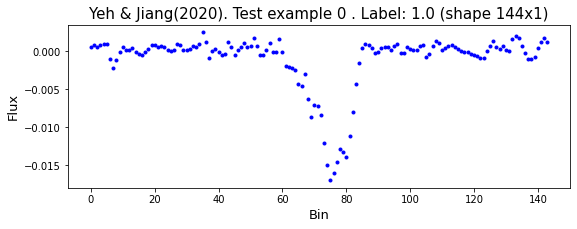

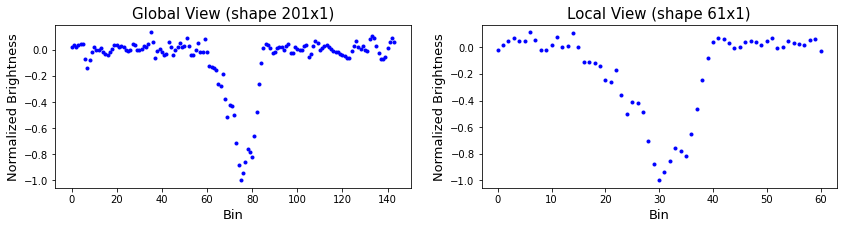

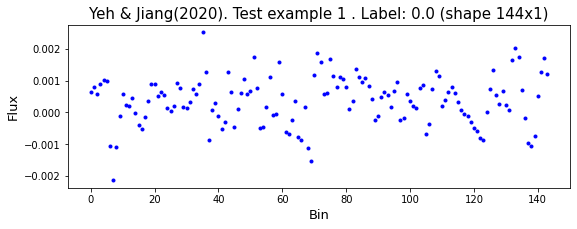

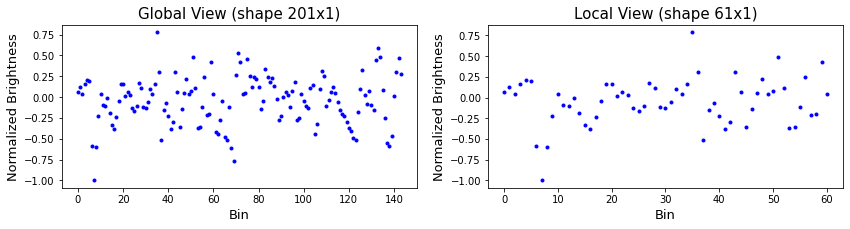

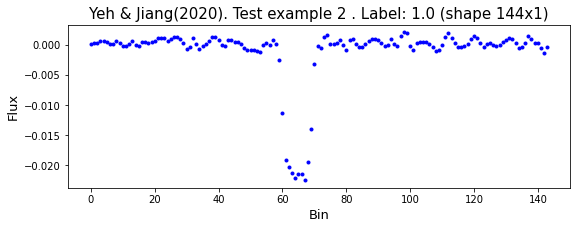

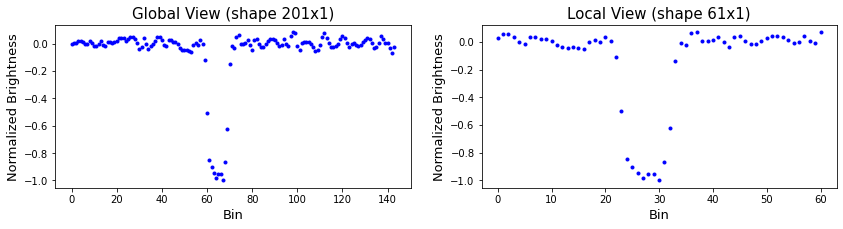

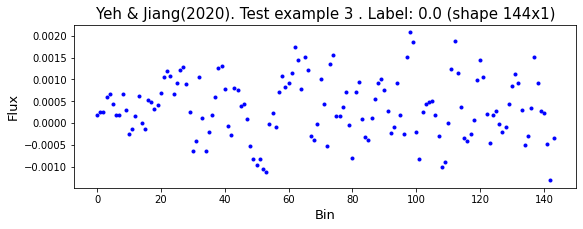

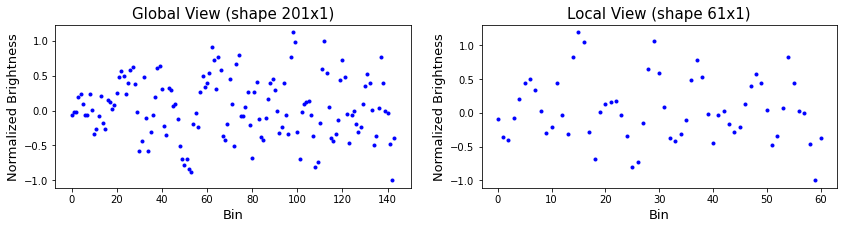

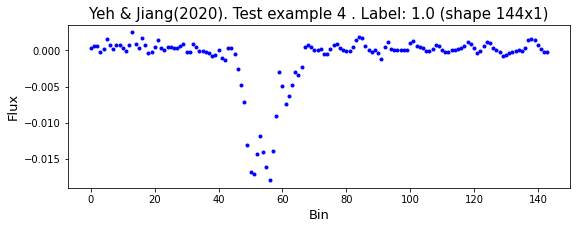

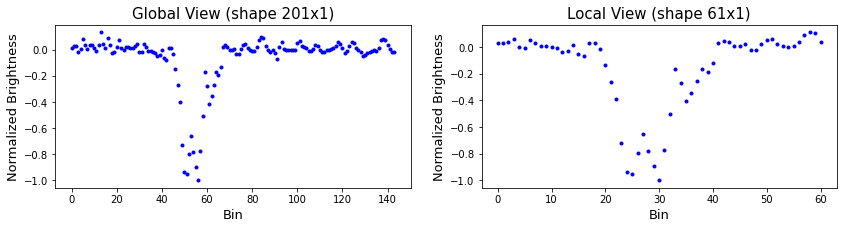

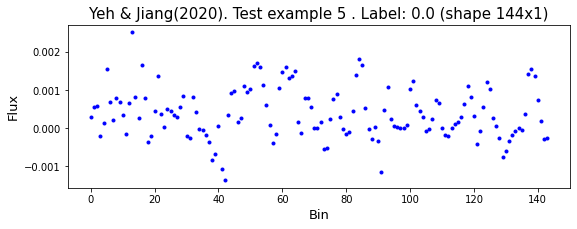

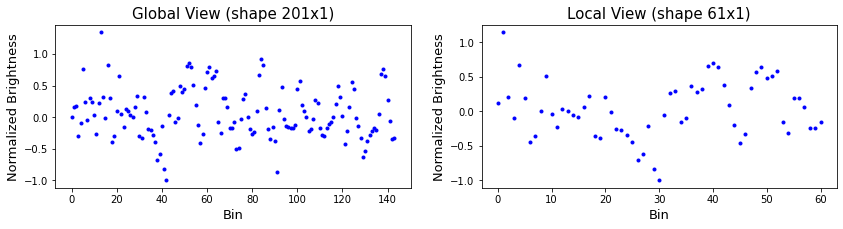

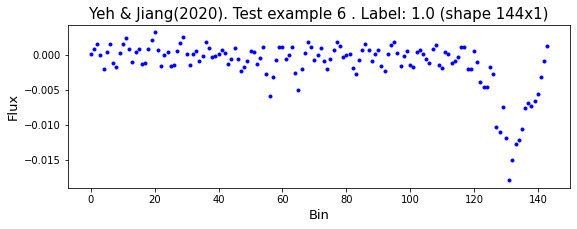

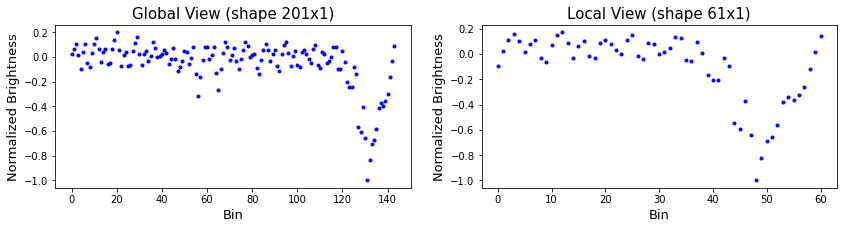

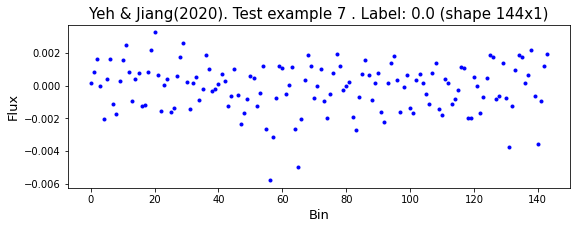

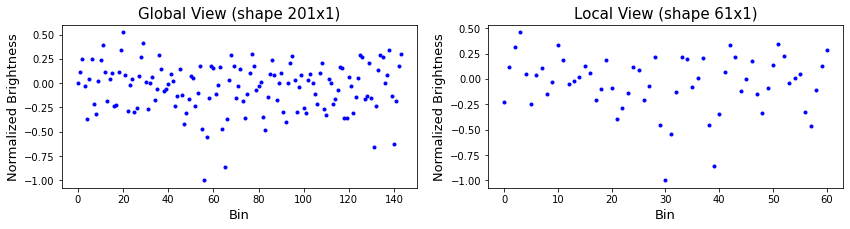

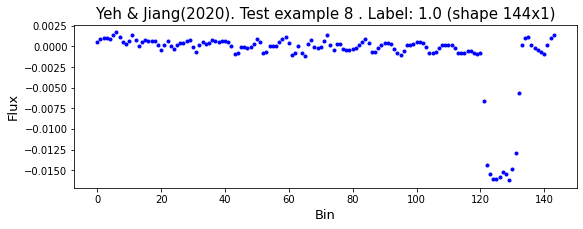

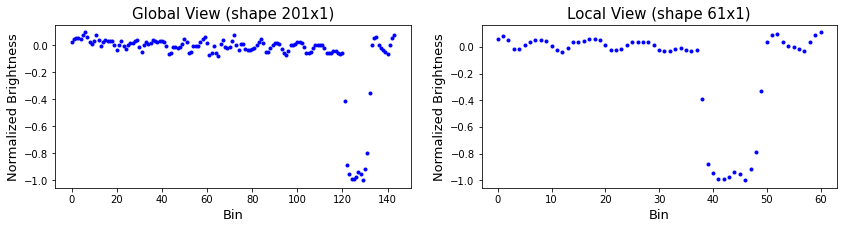

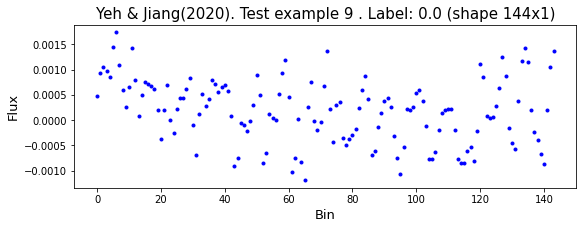

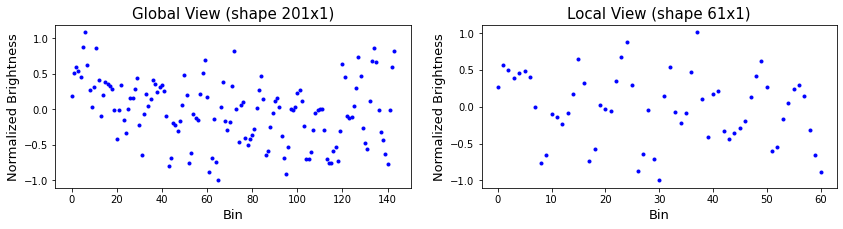

In [27]:
np.random.seed(4528132)
for idx in range(10):
    
    fig, ax = plt.subplots(figsize=(9,3))
    plt.plot(range(X_test.shape[1]), X_test[idx], '.b')
    plt.title(f"Yeh & Jiang(2020). Test example {idx} . Label: {Y_test[idx][0]} (shape 144x1)", fontsize=15)
    plt.xlabel("Bin", fontsize=13)
    plt.ylabel("Flux", fontsize=13)

    plt.show()
    
    data_local, data_global = get_example_yeh_jiang_144_61(X_test[idx])
    
    fig = plt.figure(figsize=(14, 3)) 
    
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Global View (shape 201x1)", fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    #plt.ylim(-1.1, 0.5)
    plt.plot(data_global[0, :], data_global[1,:], 'b.')
    
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Local View (shape 61x1)", fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    #plt.ylim(-1.1, 0.5)
    plt.plot(data_local[0, :], data_local[1,:], 'b.')

    

    plt.show()

In [11]:
def get_by_name(name):
    for layer in final_model_proposed.layers:
        #print(layer.name)
        if (layer.name.split("_")[-1] == name):
            print(layer.name)
            return layer

def get_by_name_weight(name):
    for layer in final_model_proposed.layers:
        #print(layer.name)
        if (layer.name.split("_")[-1] == name):
            print(layer.name)
            return layer, layer.get_weights()

def get_model_CNN1D(name, input_shape, activation_func, cnn_num_blocks, cnn_initial_num_filters, cnn_block_filter_factor, 
                    cnn_block_size, cnn_kernel_size, convolution_padding, pool_size, pool_strides):
    
    input = keras.Input(shape = input_shape, name=f'Input_{name}') # input
    x = input
    for i in range(cnn_num_blocks):
        num_filters = int(cnn_initial_num_filters *
                          cnn_block_filter_factor**i)
        print(f"block_{i+1}")
        for j in range(cnn_block_size):
            x = keras.layers.Conv1D(filters = num_filters, kernel_size = int(cnn_kernel_size), 
                                    padding=convolution_padding, activation = activation_func)(x)

        if pool_size > 1:  # pool_size 0 or 1 denotes no pooling
            x = keras.layers.MaxPooling1D(pool_size=int(pool_size), strides=int(pool_strides))(x)
    
    
    # Flatten.
    net_shape = x.get_shape().as_list()    
    
    print("NET_SHAPE: ", net_shape)
    output_dim = net_shape[1] * net_shape[2]
    print("OUTPUT_DIM: ", output_dim)
    
    output = keras.layers.Reshape( [-1, output_dim] )(x)
    model = keras.Model(inputs=input, outputs=output, name=f'Output_{name}')

    return model
        
def get_second_model_v1():
    
    print("Local")

    input_shape_l=(61,1) 
    activation_func_l='relu'
    cnn_num_blocks_l=2                    
    cnn_initial_num_filters_l=16
    cnn_block_filter_factor_l=2
    cnn_block_size_l=2
    cnn_kernel_size_l=5
    convolution_padding_l='same'
    pool_size_l=7
    pool_strides_l=2
    
    local_model = get_model_CNN1D("local", input_shape_l, activation_func_l, cnn_num_blocks_l, cnn_initial_num_filters_l, 
                    cnn_block_filter_factor_l, cnn_block_size_l, cnn_kernel_size_l, convolution_padding_l, 
                    pool_size_l, pool_strides_l)
            
    # update weight to original weights
    name_list = [514, 515, 257, 516, 517, 258, 73]
    for i, num in enumerate(name_list):
        original_layer, original_weight = get_by_name_weight(str(num))   
        local_model.layers[i+1].set_weights(original_weight)
        
    ############################################
    print("Global")
    
    num_pre_logits_hidden_layers = 4
    pre_logits_hidden_layer_size= 512
    output_dim = 1 
    input_shape_g=(144,1) 
    activation_func_g='relu' 
    cnn_num_blocks_g=5
    cnn_initial_num_filters_g=16
    cnn_block_filter_factor_g=2
    cnn_block_size_g=2 
    cnn_kernel_size_g=5
    convolution_padding_g='same'
    pool_size_g=5
    pool_strides_g=2

    global_model = get_model_CNN1D("global", input_shape_g, activation_func_g, cnn_num_blocks_g, cnn_initial_num_filters_g, 
                        cnn_block_filter_factor_g, cnn_block_size_g, cnn_kernel_size_g, convolution_padding_g, 
                        pool_size_g, pool_strides_g)

    #global_model.summary()
    
    # update weight to original weights
    name_list = [504, 505, 252, 506, 507, 253, 508, 509, 254, 510, 511, 255, 512, 513, 256] 

    for i, num in enumerate(name_list):
        original_layer, original_weight = get_by_name_weight(str(num))
        global_model.layers[i+1].set_weights(original_weight)

        
    ############################################
    combined = keras.layers.concatenate([global_model.output, local_model.output])
    
    z = keras.layers.Dense(units=512, activation="relu")(combined) # 608?

    num_pre_logits_hidden_layers = 3
    
    for i in range(num_pre_logits_hidden_layers):
         z = keras.layers.Dense(units=pre_logits_hidden_layer_size, activation="relu")(z)
    
    z = keras.layers.Dense(units = output_dim, activation = "sigmoid")(z) #  last one
    
    second_model = keras.Model(inputs=[global_model.input, local_model.input], outputs=z)

    # update weight to original weights
    name_list = [181, 182, 183]    
    for i, num in enumerate(name_list):
        original_layer, original_weight = get_by_name_weight(str(num))
        second_model.layers[i+27].set_weights(original_weight)
    
    # update weight to original weights
    old_layer_weights = get_by_name("180").get_weights()
    old_layer_weights_0 = old_layer_weights[0][:608]
    old_layer_weights_1 = old_layer_weights[1]
    second_model.layers[26].set_weights([old_layer_weights_0, old_layer_weights_1]) # dense 
    
    old_layer_weights = get_by_name("184").get_weights()
    old_layer_weights_0 = old_layer_weights[0]
    old_layer_weights_1 = old_layer_weights[1]
    second_model.layers[26+4].set_weights([old_layer_weights_0, old_layer_weights_1]) # dense last one
    
    second_model.summary()
    return second_model


def metric_a2_v1(plot = False): #  
    
    second_model = get_second_model_v1()
    predictions = []
    predictions_score = []
    true_label = []
    
    for idx in range(X_test.shape[0]): 
        #print(index)
        data_local, data_global = get_example_yeh_jiang_144_61(X_test[idx])
        
        if (plot):
            fig = plt.figure(figsize=(16, 4)) 

            ax = fig.add_subplot(1, 2, 1)
            plt.title("Global View", fontsize = 15)
            plt.xlabel("Bin", fontsize = 13)
            plt.ylabel("Normalized Brightness", fontsize = 13)
            #plt.ylim(-1.1, 0.5)
            plt.plot(data_global[0, :], data_global[1,:], 'b.')


            ax = fig.add_subplot(1, 2, 2)
            plt.title("Local View", fontsize = 15)
            plt.xlabel("Bin", fontsize = 13)
            plt.ylabel("Normalized Brightness", fontsize = 13)
            #plt.ylim(-1.1, 0.5)
            plt.plot(data_local[0, :], data_local[1,:], 'b.')
            plt.show()
        
        prediction = second_model.predict( [data_global[1,:].reshape(1,-1), data_local[1,:].reshape(1,-1)],verbose = 0 )[0][0][0]
        
        if (plot):
            print("prediction: ", prediction)
            
        predictions_score.append(prediction)
        if (prediction >= 0.5):
            predictions.append('PC')
        else:
            predictions.append('NOT_PC')

        true_label.append(Y_test[idx][0])
        
    print(len(predictions))
    print(len(true_label))

    predictions_ = []
    true_label_ = []

    for p in predictions:
        if (p == 'PC'):
            predictions_.append(1)
        else:
            predictions_.append(0)

    for l in true_label:
        if (l == 1.0):
            true_label_.append(1)
        else:
            true_label_.append(0)

    print(len(predictions_))
    print(len(true_label_))
    

    np.set_printoptions(precision=2)
    report = classification_report(true_label_, predictions_,  output_dict = True)
    auc_roc = roc_auc_score(true_label_, predictions_score)

    precision, recall, thresholds = precision_recall_curve(true_label_, predictions_score)
    auc_pr = auc(recall, precision)

    print(report)
    print()
    print("-----------")
    print("Metrics A2")
    print("-----------")
    print("Accuracy: ", report['accuracy'])
    print("PC Precision: ", report['1']['precision'])
    print("PC Recall: ", report['1']['recall'])
    print("NOT_PC Precision: ", report['0']['precision'])
    print("NOT_PC Recall: ", report['0']['recall'])
    print()
    print("auc_pr:", auc_pr)
    print("auc_roc: ", auc_roc)
    
    return keras.utils.plot_model(second_model, show_shapes=True)

Local
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
conv1d_514
conv1d_515
max_pooling1d_257
conv1d_516
conv1d_517
max_pooling1d_258
reshape_73
Global
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 1, 256]
OUTPUT_DIM:  256
conv1d_504
conv1d_505
max_pooling1d_252
conv1d_506
conv1d_507
max_pooling1d_253
conv1d_508
conv1d_509
max_pooling1d_254
conv1d_510
conv1d_511
max_pooling1d_255
conv1d_512
conv1d_513
max_pooling1d_256
dense_181
dense_182
dense_183
dense_180
dense_184
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_global (InputLayer)      [(None, 144, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 144, 16)      96          ['Input_global[0][0]']    

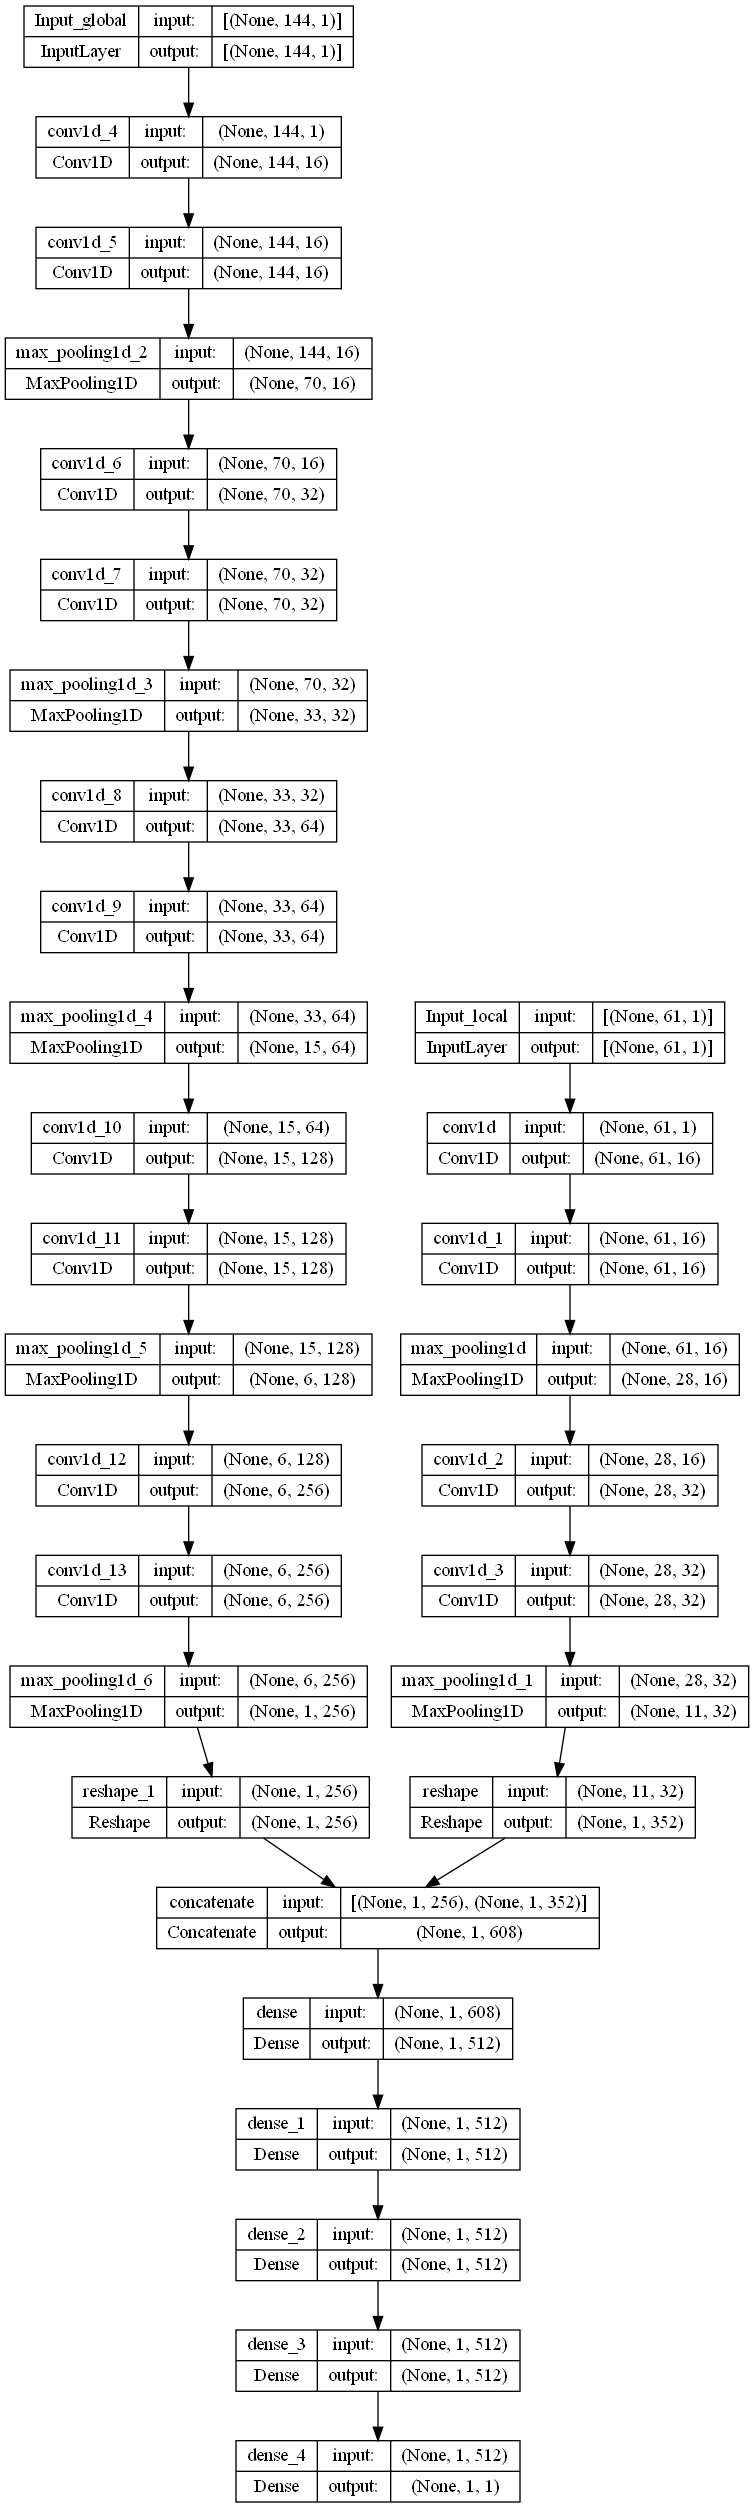

In [12]:
metric_a2_v1()

### Method 2 for calculate metrics A2

Expanding the 144x1 (Yeh and Jiang) to 201x1 for Global View input and create a 61x1 window for Local View input. Note: We cannot generate a Local View curve with the Shallue and Vanderburg (2018) proposed method  without a trial period (not provided by Yeh and Jiang).  (preserving the weights).
 

In [13]:
def get_example_yeh_jiang_201_61(data, normalize = True):
    
    #### global view ####
    new_array = np.empty([2, 201])
    new_array[0, :] = range(201)
    
    min_value_pos = np.argmin(data[:,0])
    
    if ((min_value_pos+25)> 143):
        left_data = data[:,0][0:min_value_pos-25]
        right_data = np.array([])
    elif ((min_value_pos - 25) < 0):
        left_data = np.array([])
        right_data = data[:,0][min_value_pos+25:] 
    else:
        left_data = data[:,0][0:min_value_pos-25]
        right_data = data[:,0][min_value_pos+25:]
    
    #print(left_data.shape)
    #print(right_data.shape)
    
    if (left_data.shape[0] == 0):
        left_mean = np.nan
        left_std = np.nan
    else:
        left_mean = np.mean(left_data)
        left_std = np.std(left_data)
    
    if (right_data.shape[0] == 0):
        right_mean = np.nan
        right_std = np.nan
        
    else:
        right_mean = np.mean(right_data)
        right_std = np.std(right_data)


    if (np.isnan(left_mean)):
        left_mean = right_mean
    if (np.isnan(right_mean)):
        right_mean = left_mean
    if (np.isnan(left_std)):
        left_std = right_std
    if (np.isnan(right_std)):
        right_std = left_std

    
    new_array[1, :][0:28] = np.random.normal(left_mean, left_std, 28)
    new_array[1, :][28:172] = data[:,0]
    new_array[1, :][172:201] = np.random.normal(right_mean, right_std, 29)

    data_global = new_array.copy()
    
    if (normalize): # normalize: Whether to center the median at 0 and minimum value at -1.
        data_global[1, :] -= np.median(data_global[1, :])
        data_global[1, :] /= np.abs(np.min(data_global[1, :]))  # In pathological cases, min(view) is zero...

    
    #### local view ####
    new_array = np.empty([2, 61])
    new_array[0, :] = range(61)
    
    # case 1
    #print("min_value_pos: ", min_value_pos)
    if ((min_value_pos + 31) > 143):
        new_array[1, :] = data[:,0][144-61:]
    # case 2
    elif ((min_value_pos - 30) < 0):
        new_array[1, :] = data[:,0][0:61]
    else:
        new_array[1, :] = data[:,0][min_value_pos-30:min_value_pos+31]

    data_local = new_array.copy()
    
    if (normalize): # normalize: Whether to center the median at 0 and minimum value at -1.
        data_local[1, :] -= np.median(data_local[1, :])
        data_local[1, :] /= np.abs(np.min(data_local[1, :]))  # In pathological cases, min(view) is zero...


    return data_local, data_global

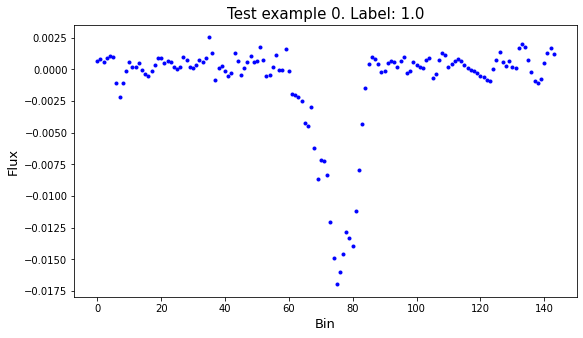

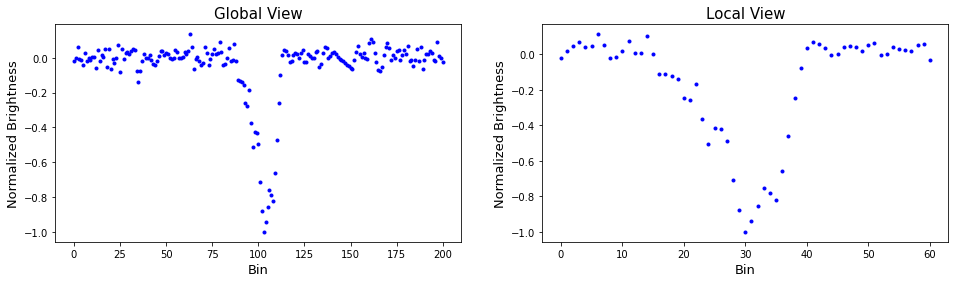

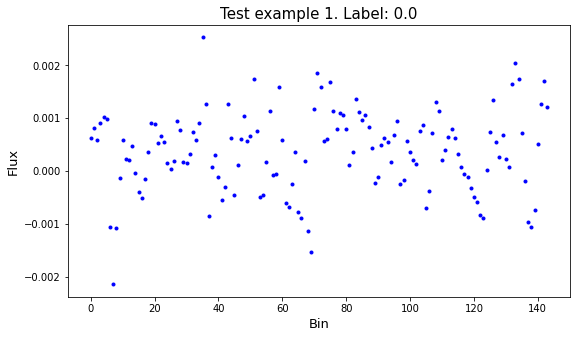

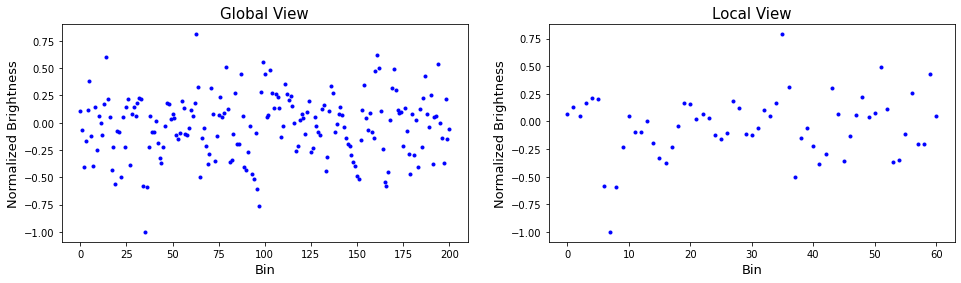

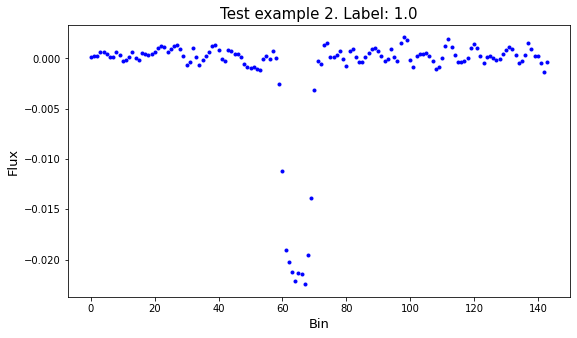

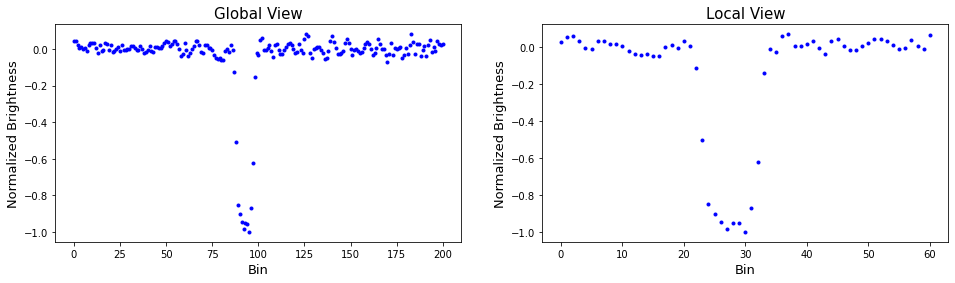

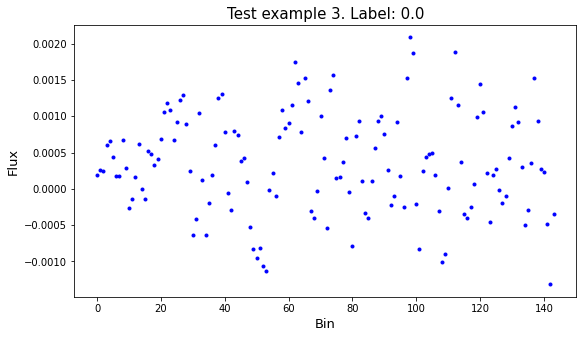

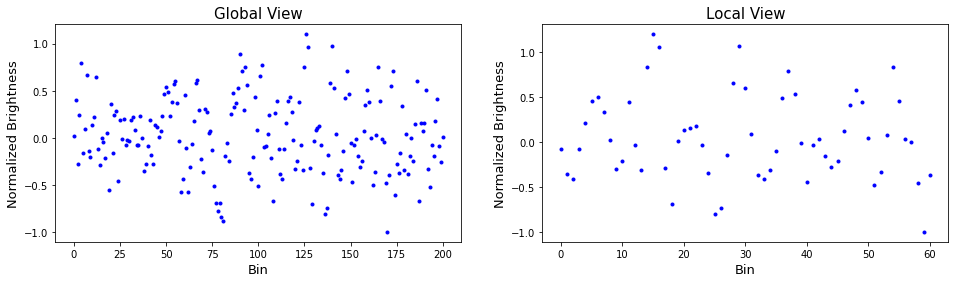

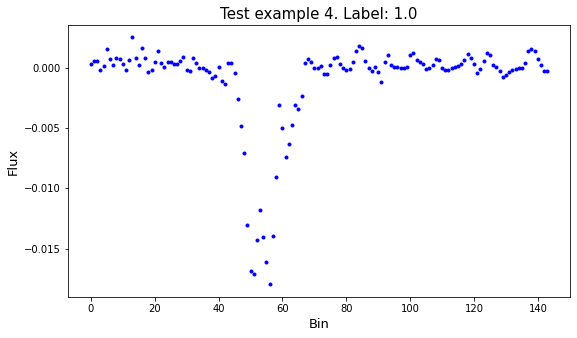

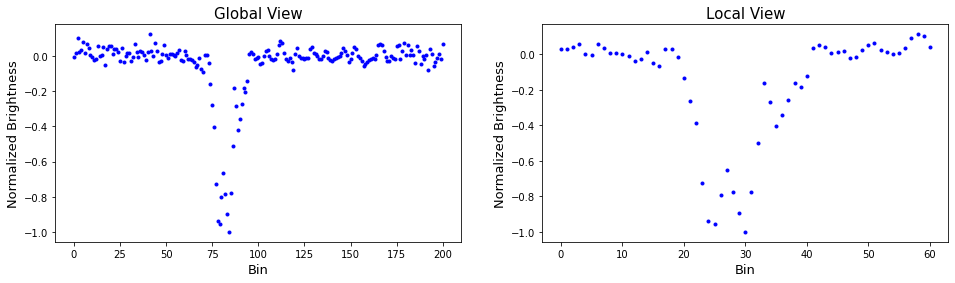

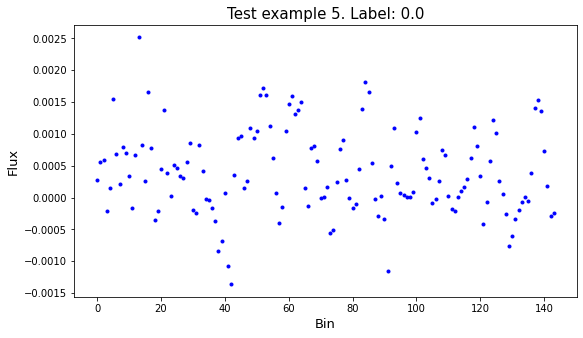

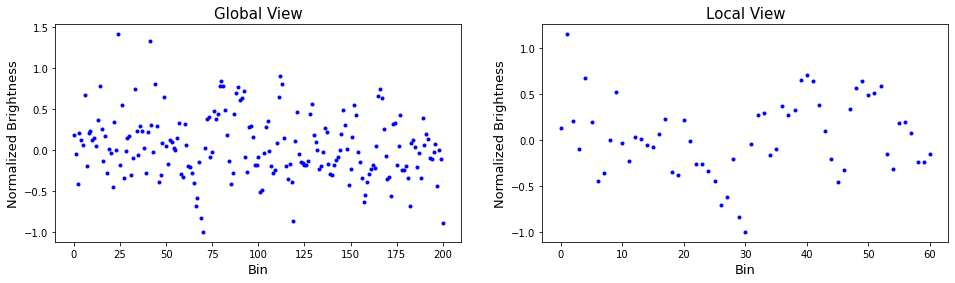

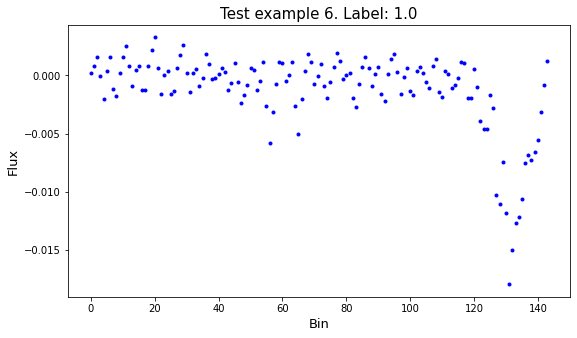

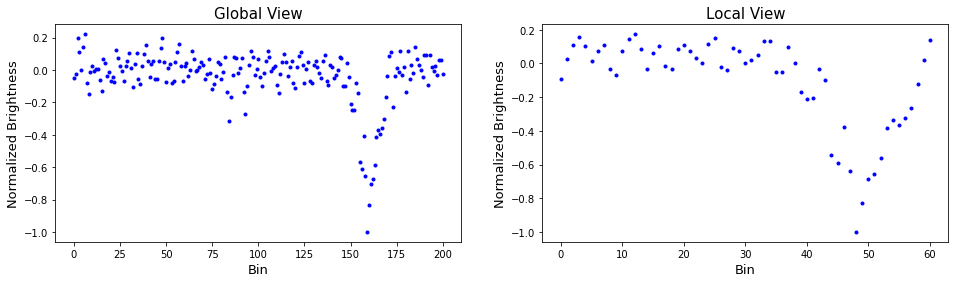

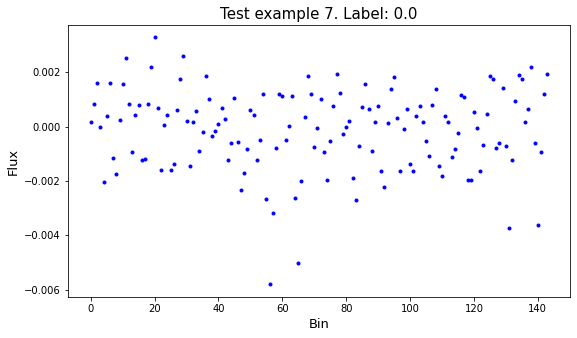

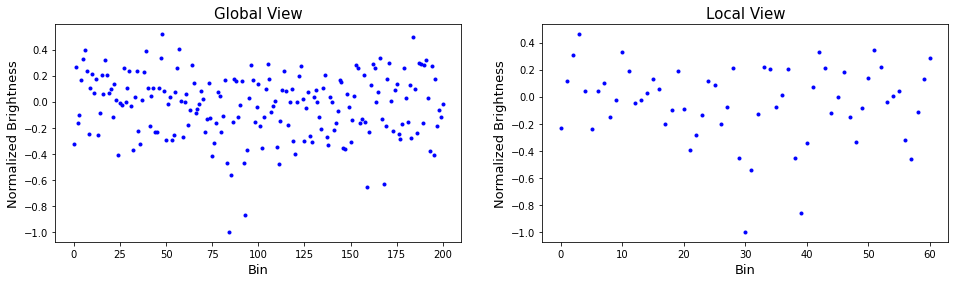

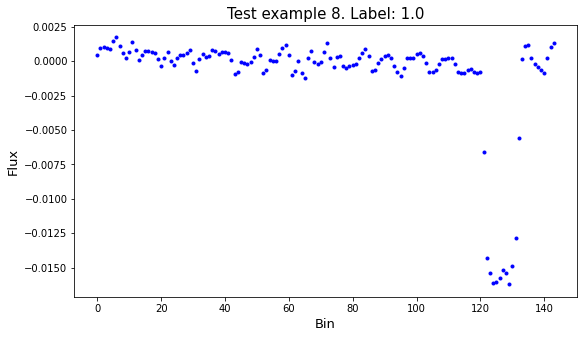

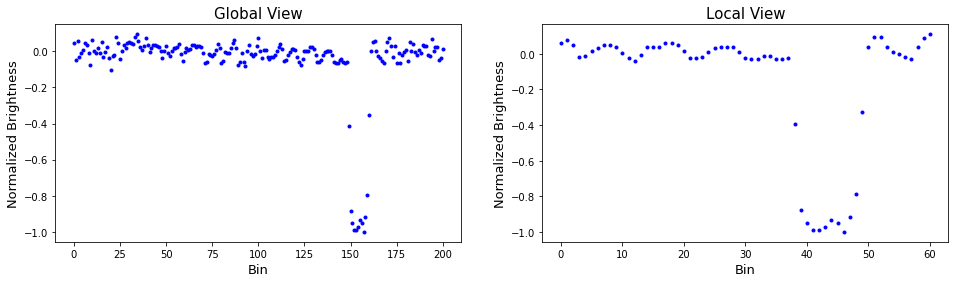

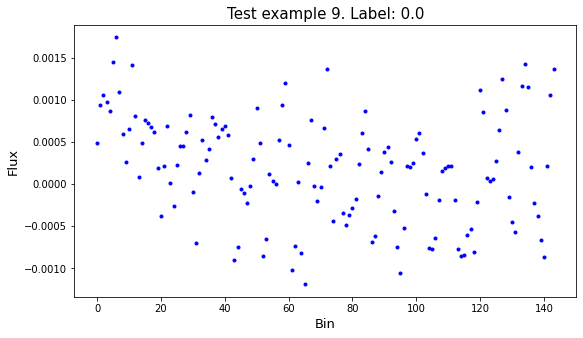

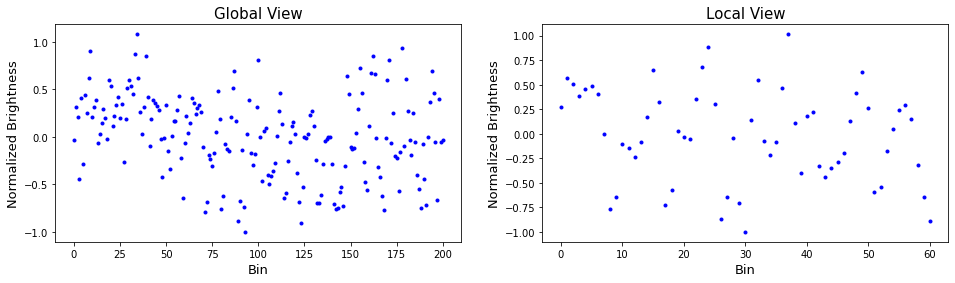

In [48]:
np.random.seed(4528132)
for idx in range(10):
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.plot(range(X_test.shape[1]), X_test[idx], '.b')
    plt.title(f"Test example {idx}. Label: {Y_test[idx][0]}", fontsize=15)
    plt.xlabel("Bin", fontsize=13)
    plt.ylabel("Flux", fontsize=13)

    plt.show()
    
    data_local, data_global = get_example_yeh_jiang_201_61(X_test[idx])
    
    fig = plt.figure(figsize=(16, 4)) 
    
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Global View", fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    #plt.ylim(-1.1, 0.5)
    plt.plot(data_global[0, :], data_global[1,:], 'b.')
    
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Local View", fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    #plt.ylim(-1.1, 0.5)
    plt.plot(data_local[0, :], data_local[1,:], 'b.')

    

    plt.show()

In [14]:
def metric_a2():
    predictions = []
    predictions_score = []
    true_label = []
    for idx in range(X_test.shape[0]): 
        #print(idx)
        data_local, data_global = get_example_yeh_jiang_201_61(X_test[idx])

        prediction = final_model_proposed.predict( [data_global[1,:].reshape(1,-1), data_local[1,:].reshape(1,-1)],verbose = 0 )[0][0][0]
        predictions_score.append(prediction)
        if (prediction >= 0.5):
            predictions.append('PC')
        else:
            predictions.append('NOT_PC')

        true_label.append(Y_test[idx][0])

    print(len(predictions))
    print(len(true_label))

    predictions_ = []
    true_label_ = []

    for p in predictions:
        if (p == 'PC'):
            predictions_.append(1)
        else:
            predictions_.append(0)

    for l in true_label:
        if (l == 1.0):
            true_label_.append(1)
        else:
            true_label_.append(0)

    print(len(predictions_))
    print(len(true_label_))
    

    np.set_printoptions(precision=2)
    report = classification_report(true_label_, predictions_,  output_dict = True)
    auc_roc = roc_auc_score(true_label_, predictions_score)

    precision, recall, thresholds = precision_recall_curve(true_label_, predictions_score)
    auc_pr = auc(recall, precision)

    print(report)
    print()
    print("-----------")
    print("Metrics A2")
    print("-----------")
    print("Accuracy: ", report['accuracy'])
    print("PC Precision: ", report['1']['precision'])
    print("PC Recall: ", report['1']['recall'])
    print("NOT_PC Precision: ", report['0']['precision'])
    print("NOT_PC Recall: ", report['0']['recall'])
    print()
    print("auc_pr:", auc_pr)
    print("auc_roc: ", auc_roc)


In [15]:
metric_a2()

9600
9600
9600
9600
{'0': {'precision': 0.9127210496292071, 'recall': 1.0, 'f1-score': 0.9543692215926036, 'support': 4800}, '1': {'precision': 1.0, 'recall': 0.904375, 'f1-score': 0.9497866754184444, 'support': 4800}, 'accuracy': 0.9521875, 'macro avg': {'precision': 0.9563605248146035, 'recall': 0.9521875, 'f1-score': 0.952077948505524, 'support': 9600}, 'weighted avg': {'precision': 0.9563605248146035, 'recall': 0.9521875, 'f1-score': 0.952077948505524, 'support': 9600}}

-----------
Metrics A2
-----------
Accuracy:  0.9521875
PC Precision:  1.0
PC Recall:  0.904375
NOT_PC Precision:  0.9127210496292071
NOT_PC Recall:  1.0

auc_pr: 0.9989305673667859
auc_roc:  0.9986603298611113


-------------------

## Yeh & Jiang




<img src="experimentos_table.png" />






Note: Yeh & Jiang provides 5 trained models:

---

name| period    | input

P12 | p = 1 ∼ 2 | 144

P23 | p = 2 ∼ 3 | 216

P34 | p = 3 ∼ 4 | 288

P45 | p = 4 ∼ 5 | 360 

### Consequently:

<b> B1 can de calculated with two methods: </b>

1) Using P23, P34 and P45 and reduce the input to 201x1 (removing the training weights necessary to adjust the new dimension).

2) Use P12 and reduce the Global View input from 201x1 to 144x1. (preserving the weights).

<b> B2 can de calculated directly </b>



### Method 1 for calculate metrics B1

Using P23, P34 and P45 and reduce the input to 201x1 (removing the training weights necessary to adjust the new dimension).

In [16]:
def method_1(model_name):
    acc_yeh = []
    pc_prec = []
    pc_recall = []
    not_pc_prec = []
    not_pc_recall = []
    auc_yeh = []
    pr_yeh = []

    for letter in  ['A', 'B', 'C', 'D', 'E']:
        fjson=f'../YehJiang/BRITE2020YehJiangCNN.tar/global/{model_name}/CNN{model_name}{letter}.json'
        json_file = open(fjson, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        CNNModelP34 = keras.models.model_from_json(loaded_model_json)

        #load weight
        CNNModelP34.load_weights(f'../YehJiang/BRITE2020YehJiangCNN.tar/global/{model_name}/CNN{model_name}{letter}.h5')

        CNNModelP34.summary()

        folder = "../GeneratedSamples"
        predictions = []
        predictions_score = []
        true_label = []

        for index in np.unique(data_test_full_proposed["index"]):
            #print(index)
            data_local, data_global, _ = get_example(index, folder, data_test_full_proposed, False)

            new_array = data_global[1,:].reshape(1,-1).copy()
            ####################################

            #prediction = final_model.predict( [data_global[1,:].reshape(1,-1), data_local[1,:].reshape(1,-1)] )[0][0][0]
            prediction = CNNModelP34.predict( new_array ,verbose = 0)[0][0]

            predictions_score.append(prediction)
            if (prediction >= 0.5):
                predictions.append('PC')
            else:
                predictions.append('NOT_PC')

            true_label.append(data_test_full_proposed[data_test_full_proposed['index'] == index]['label'].values[0])

        print(len(predictions))
        print(len(true_label))

        predictions_ = []
        true_label_ = []

        for p in predictions:
            if (p == 'PC'):
                predictions_.append(1)
            else:
                predictions_.append(0)

        for l in true_label:
            if (l == 'PC'):
                true_label_.append(1)
            else:
                true_label_.append(0)

        print("----------------------------------------")
        print(f"Model: CNN{model_name} {letter} (Method 1)")

        print(len(predictions_))
        print(len(true_label_))


        np.set_printoptions(precision=2)
        report = classification_report(true_label_, predictions_,  output_dict = True,  zero_division=0)
        
        precision, recall, thresholds = precision_recall_curve(true_label_, predictions_score)
        auc_pr = auc(recall, precision)

        auc_roc = roc_auc_score(true_label_, predictions_score)

        print(report)
        print()
        print("Accuracy: ", report['accuracy'])
        print("PC Precision: ", report['1']['precision'])
        print("PC Recall: ", report['1']['recall'])
        print("NOT_PC Recall: ", report['0']['recall'])
        print()
        print("auc_pr:", auc_pr)
        print("auc_roc: ", auc_roc)

        acc_yeh.append(report['accuracy'])
        pc_prec.append(report['1']['precision'])
        pc_recall.append(report['1']['recall'])
        not_pc_prec.append(report['0']['precision'])
        not_pc_recall.append(report['0']['recall'])
        auc_yeh.append(auc_roc)
        pr_yeh.append(auc_pr)

        print("----------------------------------------")
        
    print(acc_yeh)
    print(pc_prec)
    print(pc_recall)
    print(not_pc_prec)
    print(not_pc_recall)
    print(auc_yeh)
    print()
    print("-----------")
    print(f"Metrics B1 CNN{model_name} (method 1)")
    print("-----------")
    print("Accuracy: ", np.mean(acc_yeh))
    print("PC Precision: ", np.mean(pc_prec))
    print("PC Recall: ", np.mean(pc_recall))
    print("NOT_PC Precision: ", np.mean(not_pc_prec))
    print("NOT_PC Recall: ", np.mean(not_pc_recall))
    print("auc_pr: ", np.mean(pr_yeh))
    print("auc_roc: ", np.mean(auc_yeh))




#### CNNModelP23

In [17]:
method_1("ModelP23")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 197, 64)           384       
                                                                 
 conv1d_10 (Conv1D)          (None, 193, 64)           20544     
                                                                 
 conv1d_11 (Conv1D)          (None, 189, 64)           20544     
                                                                 
 conv1d_12 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                        

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 197, 64)           384       
                                                                 
 conv1d_18 (Conv1D)          (None, 193, 64)           20544     
                                                                 
 conv1d_19 (Conv1D)          (None, 189, 64)           20544     
                                                                 
 conv1d_20 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total para

#### CNNModelP34

In [18]:
method_1("ModelP34")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 197, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 193, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 189, 64)           20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 197, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 193, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 189, 64)           20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total para

#### CNNModelP45

In [19]:
method_1("ModelP45")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 197, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 193, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 189, 64)           20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                     

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 197, 64)           384       
                                                                 
 conv1d_18 (Conv1D)          (None, 193, 64)           20544     
                                                                 
 conv1d_19 (Conv1D)          (None, 189, 64)           20544     
                                                                 
 conv1d_20 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total para

In [46]:
print(f"Mean Accuracy:  {(0.18547140649149924 + 0.18438948995363216+ 0.1846986089644513)/3}")
print(f"Mean PC Precision:  {(0.1829466159352519 + 0.1827476514726941 + 0.1828049068759599)/3}")
print(f"Mean PC Recall:  {(1.0 + 1.0 + 1.0)/3}")
print(f"Mean NOT_PC Precision:  {(0.8 + 1.0 + 0.8)/3}")
print(f"Mean NOT_PC Recall:  {(0.003780718336483932 + 0.002457466918714556 + 0.002835538752362949)/3}")
print(f"Mean auc_pr:  {(0.5914733079676259 + 0.591373825736347 + 0.5914024534379798)/3}")
print(f"Mean auc_roc:  {(0.501890359168242 + 0.5012287334593573 + 0.5014177693761815)/3}")


Mean Accuracy:  0.1848531684698609
Mean PC Precision:  0.18283305809463526
Mean PC Recall:  1.0
Mean NOT_PC Precision:  0.8666666666666667
Mean NOT_PC Recall:  0.0030245746691871453
Mean auc_pr:  0.5914165290473176
Mean auc_roc:  0.5015122873345935


## Method 2 for calculate metrics B1


<img src="experimentos_table.png" />


B1 can de calculated with two methods:


<b>2) Use P12 and reduce the Global View input from 201x1 to 144x1.  (preserving the weights).</b> 

{'target': 'HD102249', 'satellite': 'BHr', 'label': 'PC', 'r_s': 3.47246, 'r_p': <Quantity 1.8>, 'k': 0.0532929147772961, 'p': 3.923669966090397, 'a_os': 4.201768487340627, 'i': 1.5378611386958485, 't_0': 1453.9701437868955}
(1, 144)
Denorm


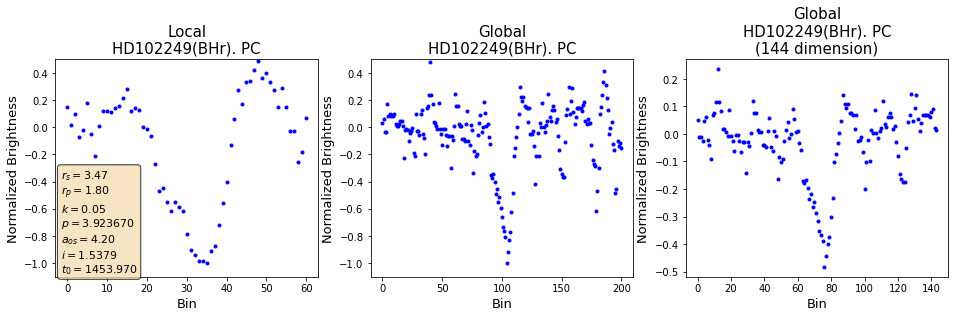

{'target': 'HD102776', 'satellite': 'BTr', 'label': 'PC', 'r_s': 3.9, 'r_p': <Quantity 1.8>, 'k': 0.047540468680359, 'p': 2.993698530087665, 'a_os': 3.2220266011534857, 'i': 1.5379070290740826, 't_0': 1436.331669935415}
(1, 144)
Denorm


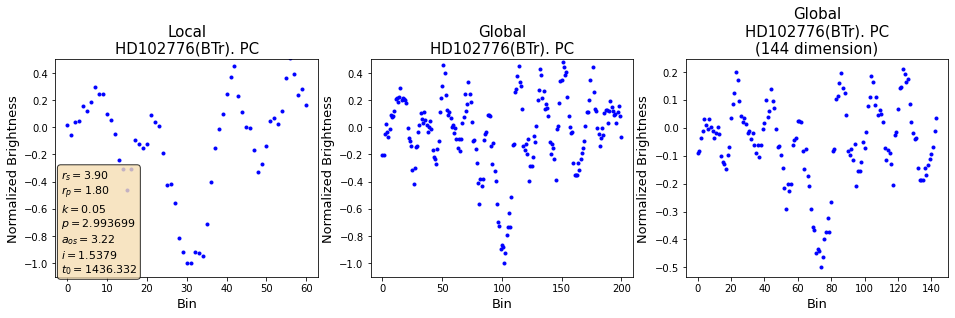

{'target': 'HD105211', 'satellite': 'UBr', 'label': 'PC', 'r_s': 1.78292, 'r_p': <Quantity 0.73>, 'k': 0.0423097424988401, 'p': 1.2638751514183773, 'a_os': 3.21681093607804, 'i': 1.568930665315968, 't_0': 1537.8432827869278}
(1, 144)
Denorm


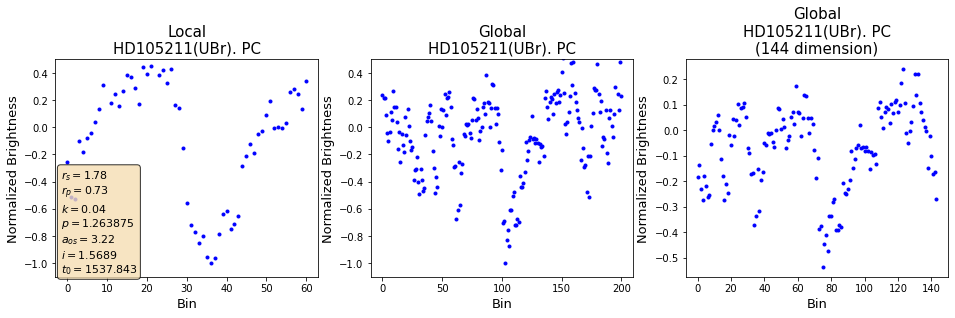

{'target': 'HD111123', 'satellite': 'UBr', 'label': 'PC', 'r_s': 1.82, 'r_p': <Quantity 1.47>, 'k': 0.0832437988600671, 'p': 2.3941246285729214, 'a_os': 4.856438090700426, 'i': 1.5481804719612884, 't_0': 1522.8563847870414}
(1, 144)
Denorm


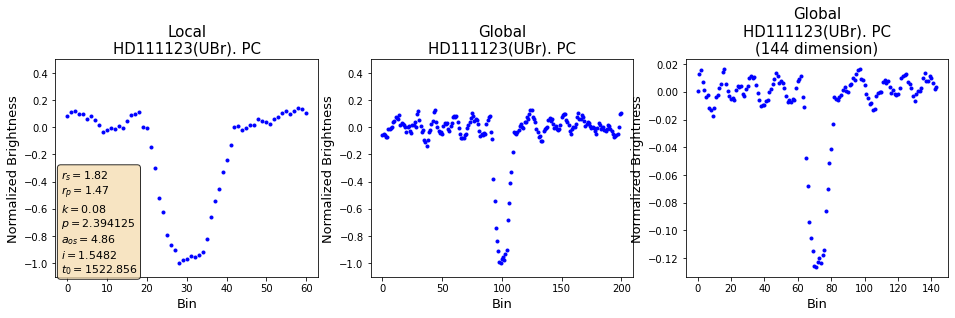

In [20]:

# Test-set Proposed (201x1 to 144 x 1input)

def plot_views_144(index, folder, data, title_local = '', title_global = '', denormalize = True):
    
    data_local, data_global, info = get_example(index, folder, data)
    print(info)
    
    ######### Create 144 input #########
    new_array = np.empty([1, 144])
    new_array[0] = data_global[1,:].reshape(1,-1)[0][28:-29] 
    print(new_array.shape)
    
    if (denormalize): # normalize: Whether to center the median at 0 and minimum value at -1.
        print("Denorm")
        new_array[0] *= np.abs(np.max(new_array[0]))  # In pathological cases, min(view) is zero...
        new_array[0] += np.median(new_array[0])
        
        #if (normalize): # normalize: Whether to center the median at 0 and minimum value at -1.
        #    data_global -= np.median(data_global)
        #    data_global /= np.abs(np.min(data_global))  # In pathological cases, min(view) is zero...


    ####################################
    
    textstr = '\n'.join((
        r'$r_{s}=%.2f$' % (info['r_s'], ),
        r'$r_{p}=%.2f$' % (info['r_p'], ),
        r'$k=%.2f$' % (info['k'], ),
        r'$p=%.6f$' % (info['p'], ),
        r'$a_{os}=%.2f$' % (info['a_os'], ),
        r'$i=%.4f$' % (info['i'], ),
        r'$t_{0}=%.3f$' % (info['t_0'], )
    ))
    
    title_local += f"Local\n{info['target']}({info['satellite']}). {info['label']}"
    title_global += f"Global\n{info['target']}({info['satellite']}). {info['label']}"

    fig = plt.figure(figsize=(16, 4)) 
    ax = fig.add_subplot(1, 3, 1)
    plt.title(title_local, fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    plt.ylim(-1.1, 0.5)
    plt.plot(data_local[0, :], data_local[1,:], 'b.')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    ax.text(0.02, 0.5, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)

    ax = fig.add_subplot(1, 3, 2)
    plt.title(title_global, fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    plt.ylim(-1.1, 0.5)
    plt.plot(data_global[0, :], data_global[1,:], 'b.')

    
    ax = fig.add_subplot(1, 3, 3)
    plt.title(title_global + '\n(144 dimension)', fontsize = 15)
    plt.xlabel("Bin", fontsize = 13)
    plt.ylabel("Normalized Brightness", fontsize = 13)
    #plt.ylim(-1.1, 0.5)
    plt.plot(range(144), new_array[0], 'b.')

    plt.show()
    

    
folder = "../GeneratedSamples"

for idx in [39, 400, 610, 2470]: # modify for a specific index 
    plot_views_144(idx, folder, data_train_full_proposed, denormalize = True)


In [21]:
def method_2():
    acc_yeh = []
    pc_prec = []
    pc_recall = []
    not_pc_prec = []
    not_pc_recall = []
    auc_yeh = []
    pr_yeh = []

    for letter in ['A', 'B', 'C', 'D', 'E']:
        fjson=f'../YehJiang/ModelP12/CNNModelP12{letter}.json'
        json_file = open(fjson, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        CNNModelP12 = keras.models.model_from_json(loaded_model_json)

        #load weight
        CNNModelP12.load_weights(f'../YehJiang/ModelP12/CNNModelP12{letter}.h5')

        CNNModelP12.summary()

        folder = "../GeneratedSamples"
        predictions = []
        predictions_score = []
        true_label = []

        for index in np.unique(data_test_full_proposed["index"]):
            #print(index)
            data_local, data_global, _ = get_example(index, folder, data_test_full_proposed, False)

            ######### Create 144 input ######### 
            new_array = np.empty([1, 144])
            new_array[0] = data_global[1,:].reshape(1,-1)[0][28:-29]
            #print(new_array.shape)

            new_array[0] *= np.abs(np.max(new_array[0]))  # In pathological cases, min(view) is zero...
            new_array[0] += np.median(new_array[0])

            #if (normalize): # normalize: Whether to center the median at 0 and minimum value at -1.
            #    data_global -= np.median(data_global)
            #    data_global /= np.abs(np.min(data_global))  # In pathological cases, min(view) is zero...


            ####################################

            #prediction = final_model.predict( [data_global[1,:].reshape(1,-1), data_local[1,:].reshape(1,-1)] )[0][0][0]
            prediction = CNNModelP12.predict( new_array ,verbose = 0)[0][0]

            predictions_score.append(prediction)
            if (prediction >= 0.5):
                predictions.append('PC')
            else:
                predictions.append('NOT_PC')

            true_label.append(data_test_full_proposed[data_test_full_proposed['index'] == index]['label'].values[0])

        print(len(predictions))
        print(len(true_label))

        predictions_ = []
        true_label_ = []

        for p in predictions:
            if (p == 'PC'):
                predictions_.append(1)
            else:
                predictions_.append(0)

        for l in true_label:
            if (l == 'PC'):
                true_label_.append(1)
            else:
                true_label_.append(0)

        print("----------------------------------------")
        print(f"Model: CNNModelP12{letter}")

        print(len(predictions_))
        print(len(true_label_))


        np.set_printoptions(precision=2)
        report = classification_report(true_label_, predictions_,  output_dict = True)

        precision, recall, thresholds = precision_recall_curve(true_label_, predictions_score)
        auc_pr = auc(recall, precision)

        auc_roc = roc_auc_score(true_label_, predictions_score)

        print(report)
        print()
        print("Accuracy: ", report['accuracy'])
        print("PC Precision: ", report['1']['precision'])
        print("PC Recall: ", report['1']['recall'])
        print("NOT_PC Precision: ", report['0']['precision'])
        print("NOT_PC Recall: ", report['0']['recall'])
        print()
        print("auc_pr:", auc_pr)
        print("auc_roc: ", auc_roc)

        acc_yeh.append(report['accuracy'])
        pc_prec.append(report['1']['precision'])
        pc_recall.append(report['1']['recall'])
        not_pc_prec.append(report['0']['precision'])
        not_pc_recall.append(report['0']['recall'])
        auc_yeh.append(auc_roc)
        pr_yeh.append(auc_pr)

    print("----------------------------------------")

    print(acc_yeh)
    print(pc_prec)
    print(pc_recall)
    print(not_pc_prec)
    print(not_pc_recall)
    print(auc_yeh)
    print()
    print("-----------")
    print("Metrics B1")
    print("-----------")
    print("Accuracy: ", np.mean(acc_yeh))
    print("PC Precision: ", np.mean(pc_prec))
    print("PC Recall: ", np.mean(pc_recall))
    print("NOT_PC Precision: ", np.mean(not_pc_prec))
    print("NOT_PC Recall: ", np.mean(not_pc_recall))
    print("auc_pr: ", np.mean(pr_yeh))
    print("auc_roc: ", np.mean(auc_yeh))




In [22]:
method_2()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 140, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 136, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 132, 64)           20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 64)           20544     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                     

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 140, 64)           384       
                                                                 
 conv1d_18 (Conv1D)          (None, 136, 64)           20544     
                                                                 
 conv1d_19 (Conv1D)          (None, 132, 64)           20544     
                                                                 
 conv1d_20 (Conv1D)          (None, 128, 64)           20544     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total para

## Metrics B2


<img src="experimentos_table.png"/>


In [23]:
def metric_b2():
    acc_yeh = []
    pc_prec = []
    pc_recall = []
    not_pc_prec = []
    not_pc_recall = []
    auc_yeh = []
    pr_yeh = []

    for letter in ['A', 'B', 'C', 'D', 'E']:
        fjson=f'../YehJiang/ModelP12/CNNModelP12{letter}.json'
        json_file = open(fjson, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        CNNModelP12 = keras.models.model_from_json(loaded_model_json)

        #load weight
        CNNModelP12.load_weights(f'../YehJiang/ModelP12/CNNModelP12{letter}.h5')

        CNNModelP12.summary()

        folder = "GeneratedSamples"
        predictions = []
        predictions_score = []
        true_label = []

        for idx in range(X_test.shape[0]): 

            prediction = CNNModelP12.predict( X_test[idx].reshape(1,-1),verbose = 0)[0][0]

            predictions_score.append(prediction)
            if (prediction >= 0.5):
                predictions.append('PC')
            else:
                predictions.append('NOT_PC')

            true_label.append(Y_test[idx][0])

        print(len(predictions))
        print(len(true_label))

        predictions_ = []
        true_label_ = []

        for p in predictions:
            if (p == 'PC'):
                predictions_.append(1)
            else:
                predictions_.append(0)

        for l in true_label:
            if (l == 1.0):
                true_label_.append(1)
            else:
                true_label_.append(0)

        print("----------------------------------------")
        print(f"Model: CNNModelP12{letter}")

        print(len(predictions_))
        print(len(true_label_))


        np.set_printoptions(precision=2)
        report = classification_report(true_label_, predictions_,  output_dict = True)

        precision, recall, thresholds = precision_recall_curve(true_label_, predictions_score)
        auc_pr = auc(recall, precision)

        auc_roc = roc_auc_score(true_label_, predictions_score)

        print(report)
        print()
        print("Accuracy: ", report['accuracy'])
        print("PC Precision: ", report['1']['precision'])
        print("PC Recall: ", report['1']['recall'])
        print("NOT_PC Precision: ", report['0']['precision'])
        print("NOT_PC Recall: ", report['0']['recall'])
        print("auc_pr:", auc_pr)
        print("auc_roc: ", auc_roc)

        acc_yeh.append(report['accuracy'])
        pc_prec.append(report['1']['precision'])
        pc_recall.append(report['1']['recall'])
        not_pc_prec.append(report['0']['precision'])
        not_pc_recall.append(report['0']['recall'])
        auc_yeh.append(auc_roc)
        pr_yeh.append(auc_pr)

    print("----------------------------------------")

    print(acc_yeh)
    print(pc_prec)
    print(pc_recall)
    print(not_pc_prec)
    print(not_pc_recall)
    print(auc_yeh)
    print()
    print("-----------")
    print("Metrics B2")
    print("-----------")
    print("Accuracy: ", np.mean(acc_yeh))
    print("PC Precision: ", np.mean(pc_prec))
    print("PC Recall: ", np.mean(pc_recall))
    print("NOT_PC Precision: ", np.mean(not_pc_prec))
    print("NOT_PC Recall: ", np.mean(not_pc_recall))
    print("auc_pr: ", np.mean(pr_yeh))
    print("auc_roc: ", np.mean(auc_yeh))




In [24]:
metric_b2()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 140, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 136, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 132, 64)           20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 64)           20544     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                     

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 140, 64)           384       
                                                                 
 conv1d_18 (Conv1D)          (None, 136, 64)           20544     
                                                                 
 conv1d_19 (Conv1D)          (None, 132, 64)           20544     
                                                                 
 conv1d_20 (Conv1D)          (None, 128, 64)           20544     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total para